In [260]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta


import warnings
from operator import attrgetter


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors



SyntaxError: invalid syntax (<ipython-input-260-4fd8889b8806>, line 16)

In [178]:
#Импортируем датасеты:
customers_df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-stojanov-21/first_project_datasets/olist_customers_dataset.csv")

orders_df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-stojanov-21/first_project_datasets/olist_orders_dataset.csv")

items_df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-stojanov-21/first_project_datasets/olist_order_items_dataset.csv")

## Подготовим данные, соберем всё в кучу, приведём типы и прочее:

In [179]:
customers_orders = customers_df.merge(orders_df, how = 'inner', on = 'customer_id')

In [180]:
customers_orders_items = customers_orders.merge(items_df, how = 'inner', on = 'order_id')

In [181]:
customers_orders_items.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [182]:
sales = customers_orders_items

In [183]:
sales['order_purchase_timestamp'] = pd.to_datetime(sales.order_purchase_timestamp)

In [184]:
sales = sales.query("order_purchase_timestamp > '2016-12-31' & order_purchase_timestamp < '2018-1-1'")

### Немного посмотрим на данные:

In [185]:
print('{:,} rows; {:,} columns'.format(sales.shape[0], sales.shape[1]))


50,864 rows; 18 columns


In [186]:
print('{:,} invoices don\'t have a customer id'.format(sales[sales.customer_unique_id.isnull()].shape[0]))


0 invoices don't have a customer id


In [187]:
print('Orders from {} to {}'.format(sales['order_purchase_timestamp'].min(),
                                    sales['order_purchase_timestamp'].max()))

Orders from 2017-01-05 11:56:06 to 2017-12-31 23:29:31


In [188]:
sales['customer_unique_id'].value_counts().to_frame().customer_unique_id.mean()


1.1767264314632735

In [189]:
sales['customer_unique_id'].nunique()

43225

In [190]:
sales.duplicated(["order_id"])

0         False
5         False
7         False
10        False
12        False
          ...  
112639    False
112642    False
112644    False
112648    False
112649    False
Length: 50864, dtype: bool

### Посчитаем, сколько каждый пользователь оставил денег в магазине 

In [191]:
orders = sales.groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id']) \
              .agg({'price': lambda x: x.sum()}).reset_index()

In [192]:
orders.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.9
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.9
2,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.9
3,00048cc3ae777c65dbb7d2a0634bc1ea,2017-05-15 21:42:34,85c835d128beae5b4ce8602c491bf385,21.9
4,00054e8431b9d7675808bcb819fb4a32,2017-12-10 11:53:48,635d9ac1680f03288e72ada3a1035803,19.9


### Задаем период расчёта

In [193]:
NOW = orders['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-01-01 23:29:31')

In [194]:
period = 365

## Приступаем к анализу

**R** - время от последней покупки пользователя до текущей даты,   
**F** - суммарное количество покупок у пользователя за всё время,   
**M** - сумма покупок за всё время

Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик **recency**, **frequency** и **monetary** для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

### Считаю recency, frequency и monetary по пользователям

In [195]:
orders['DaysSinceOrder'] = orders['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)

In [196]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # число дней с последнего заказа
    'order_purchase_timestamp': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # Частота
}
rfm = orders.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'order_purchase_timestamp': 'Frequency'}, inplace=True)
rfm.head()

,customer_unique_id,Recency,Frequency
0,0000f46a3911fa3c0805444483337064,297,1
1,0000f6ccb0745a6a4b88665a16c9f078,81,1
2,0004aac84e0df4da2b147fca70cf8255,48,1
3,0005e1862207bf6ccc02e4228effd9a0,302,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1


### Добавляю сумму покупок по пользователям

In [197]:
rfm['Monetary'] = rfm['customer_unique_id'].apply(lambda x: orders[(orders['customer_unique_id'] == x) & \
                                                           (orders['order_purchase_timestamp'] >= NOW - timedelta(days=period))]\
                                                           ['price'].sum())
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,297,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90


## Теперь надо определиться с сегментированием.

Насколько я понял в идеальной ситуации сегменты должны быть примерно равны. Однако если посмотреть на данные (ниже). Видно что у нас они распределены не равномерно. 

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


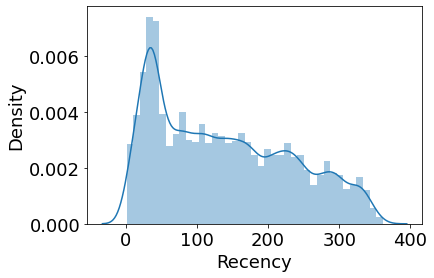

In [272]:
sns.distplot(rfm.Recency)


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


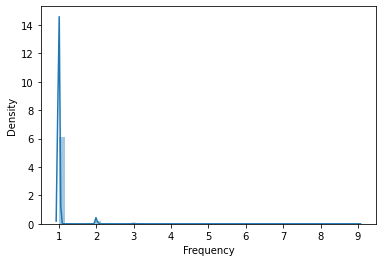

In [200]:
sns.distplot(rfm.Frequency)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


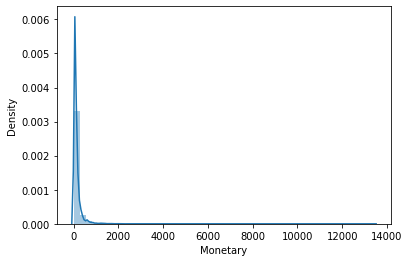

In [202]:
sns.distplot(rfm.Monetary)

Неравномерность распределения особенно касается частоты покупок. Так вышло что в магазине в 97% случаев заказывали всего один раз (ниже).  

In [201]:
rfm['Frequency'].quantile([.97, .98, .999, .99999])

0.97000    1.00000
0.98000    2.00000
0.99900    3.00000
0.99999    7.70328
Name: Frequency, dtype: float64

Думаю разбить на три квантиля (0-33, 33-66, 66 - 100), а частоту вручную - отделить тех кто сделал всего одну покупку от остальных: 

In [235]:
rfm['R'] = pd.qcut(rfm['Recency'], 3, labels=[1, 2, 3]).astype(str)
rfm['M'] = pd.qcut(rfm['Monetary'], 3, labels=[1, 2, 3]).astype(str)
rfm['F'] = rfm['Frequency'].apply(lambda x: '1' if x==1 else '2')

rfm['RFM Score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']

In [236]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,R_score,M_score,F_score,RFM_score,RFM score
0,0000f46a3911fa3c0805444483337064,297,1,69.00,3,1,2,312,hibernating,3,2,1,312,312
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,2,1,1,211,promising,2,1,1,211,211
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,1,1,3,113,promising,1,3,1,113,113
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00,3,1,3,313,hibernating,3,3,1,313,313
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,2,1,1,211,hibernating,2,1,1,211,211


`main` - '123' - основные клиенты (наиболее ценныe клиенты) те кто заказывает часто на небольшой объем  
`gone` - '311', '312', '313' - ушедшие (заказавшие только раз)  
`newbies` - '111', '112', '113' - новички (заказавшие только раз, но недавно)  
`whales` - '323', '213', '223 - "киты продаж" но наоборот (те кто генерирует большую часть прибыли)  
`loyal` - '221', '222', '321', '322' - лояльные пользователи (заказывают нечасто но плюс минус постоянно)   
`nomral` - '121', '122', '211', '212', - обычные пользователи  (часто и регулярно)

In [237]:
def segment(x):
    if x == '123':
        return 'main'
    elif x in ['311', '312', '313']:
        return 'gone'
    elif x in ['111', '112', '113']:
        return 'newbies'
    elif x in ['323', '213', '223']:
        return 'whales'
    elif x in ['221', '222', '321', '322']:
        return 'loyal'
    else:
        return 'nomral'

In [239]:
rfm['segments'] = rfm['RFM_score'].apply(segment)
rfm['segments'].value_counts(normalize=True)*100

gone       32.506651
newbies    32.451128
nomral     22.207056
whales     11.514170
main        0.691729
loyal       0.629265
Name: segments, dtype: float64

получается средних пользователей почти нет

## Границы метрик recency, frequency и monetary для каждого сегмента 

In [246]:
rfm.groupby("RFM score").agg({"Recency" : [min, max], 
                             "Frequency" : [min, max],
                            "Monetary" : [min, max]})

Recency      Frequency     Monetary          
              min  max       min max      min       max
RFM score                                              
111             1   73         1   1     3.85     58.99
112             1   73         1   1    59.00    125.90
113             1   73         1   1   125.93   5934.60
121            15   67         2   2    25.80     58.99
122             1   72         2   2    59.70    125.89
123             3   73         2   9   127.40   2009.98
211            74  179         1   1     2.29     58.99
212            74  179         1   1    59.00    125.90
213            74  179         1   1   125.93  13440.00
221            74  175         2   2    13.90     56.99
222            74  179         2   3    59.80    125.80
223            74  179         2   4   126.46   3999.98
311           180  361         1   1     3.90     58.99
312           180  361         1   1    59.00    125.90
313           180  360         1   1   125.93   6735.00
321           181  361         2   6    20.70     58.40
322           181  349         2   4    59.80    125.80
323           180  358         2   4   125.98   7388.00

# Визуализируем сегменты

In [251]:
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,R_score,M_score,F_score,RFM_score,RFM score,segments
0,0000f46a3911fa3c0805444483337064,297,1,69.00,3,1,2,312,hibernating,3,2,1,312,312,gone
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,2,1,1,211,promising,2,1,1,211,211,nomral
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,1,1,3,113,promising,1,3,1,113,113,newbies
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00,3,1,3,313,hibernating,3,3,1,313,313,gone
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,2,1,1,211,hibernating,2,1,1,211,211,nomral


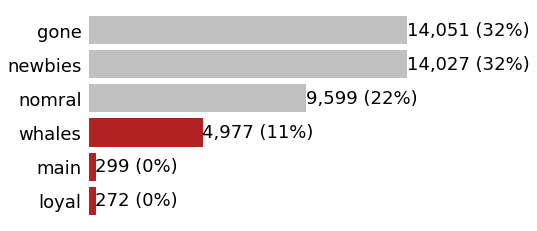

In [270]:
# count the number of customers in each segment
segments_counts = rfm['segments'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['loyal', 'whales', 'main']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [ ]:
main - '123' - основные клиенты (наиболее ценныe клиенты) те кто заказывает часто на небольшой объем
gone - '311', '312', '313' - ушедшие (заказавшие только раз)
newbies - '111', '112', '113' - новички
whales - '323', '213', '223 - "киты продаж" но наоборот (те кто генерирует большую часть прибыли)
loyal - '221', '222', '321', '322' - лояльные пользователи
nomral - '121', '122', '211', '212', - обычные пользователи